# COF Zarr Access via Reformat

imported on: **2023-09-14**

<p>This notebook is from a different repository in NASA's PO.DAAC, ECCO.</p>

> The original source for this document is [https://github.com/podaac/ECCO/blob/main/Data_Access/cloud_harmony_zarr_reformat.ipynb](https://github.com/podaac/ECCO/blob/main/Data_Access/cloud_harmony_zarr_reformat.ipynb)

# Access ECCO data via Harmony & the Zarr reformatter service

This notebook leverages the Zarr reformatter service (available through [Harmony API](https://harmony.earthdata.nasa.gov/)) to access ocean bottom pressure (OBP) data from ECCO V4r4 in Zarr format (instead of native netCDF4 file format).

## Getting Started

We will access monthly ocean bottom pressure (OBP) data from ECCO V4r4 ([10.5067/ECG5M-OBP44](https://doi.org/10.5067/ECG5M-OBP44)), which are provided as a monthly time series on a 0.5-degree latitude/longitude grid. 

The data are archived in netCDF format. However, this notebook demonstration will request conversion to Zarr format for files covering the period between 2010 and 2018. Upon receiving our request, Harmony's backend will convert the files and stage them in S3 for native access in AWS (`us-west-2` region, specifically). We will access the new Zarr datasets as an aggregated dataset using xarray, and leverage the S3 native protocols for direct access to the data in an efficient manner.

<img src="https://podaac.jpl.nasa.gov/Podaac/thumbnails/ECCO_L4_OBP_05DEG_MONTHLY_V4R4.jpg" width="50%" />

### Requirements

#### AWS

This notebook should be running in an EC2 instance in AWS region *us-west-2*, as previously mentioned. We recommend using an EC2 with at least 8GB of memory available. 

The notebook was developed and tested using a *t2.large* instance (2 cpus; 8GB memory).

#### Python 3

Most of these imports are from the Python standard library. However, you will need to install these packages into your Python 3 environment if you have not already done so:

* s3fs
* requests
* pandas
* xarray
* matplotlib

### Requirements

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import requests
import json
import time
import s3fs

ShortName = "ECCO_L4_OBP_05DEG_MONTHLY_V4R4"

### Study period

Set some "master" inputs to define the time and place contexts for our case studies in the ipynb. This example will be requesting time subsets and receiving global data back from the Harmony API.

In [2]:
start_date = "2010-01-01"
end_date   = "2018-12-31"

### Data Access

Some features in the Harmony API require us to identify the target dataset/collection by its *concept-id* (which uniquely idenfifies it among the other datasets in the Common Metadata Repository). Support for selection by the dataset *ShortName* will be added in a future release.

#### Common Metadata Repository (CMR)

For now, we will need to get the *concept-id* that corresponds to our dataset by accessing its metadata from the CMR. Read more about the CMR at: https://cmr.earthdata.nasa.gov/

Request the UMM Collection metadata (i.e. metadata about the dataset) from the CMR and select the *concept-id* as a new variable *ccid*.

In [3]:
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

ummc = response.json()['items'][0]

ccid = ummc['meta']['concept-id']

ccid

'C1990404791-POCLOUD'

#### Harmony API

And get the Harmony API endpoint and zarr parameter like we did for SMAP before:

In [4]:
base = f"https://harmony.earthdata.nasa.gov/{ccid}"
hreq = f"{base}/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset"
rurl = f"{hreq}?format=application/x-zarr"

print(rurl)

https://harmony.earthdata.nasa.gov/C1990404791-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr


ECCO monthly collections have 312 granules in V4r4 (you can confirm with the granule listing from CMR Search API) so we can get the entire time series for 2010 to 2018 with one request to the Harmony API.

Format a string of query parameters to limit the processing to the desired time period. Then, append the string of time subset parameters to the variable *`rurl`*.

In [5]:
subs = '&'.join([f'subset=time("{start_date}T00:00:00.000Z":"{end_date}T23:59:59.999Z")'])

rurl = f"{rurl}&{subs}"

print(rurl)

https://harmony.earthdata.nasa.gov/C1990404791-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr&subset=time("2010-01-01T00:00:00.000Z":"2018-12-31T23:59:59.999Z")


Submit the request and monitor the processing status in a *while* loop, breaking it on completion of the request job:

In [6]:
response = requests.get(url=rurl).json()

# Monitor status in a while loop. Wait 10 seconds for each check.
wait = 10
while True:
    response = requests.get(url=response['links'][0]['href']).json()
    if response['status']!='running':
        break
    print(f"Job in progress ({response['progress']}%)")
    time.sleep(wait)

print("DONE!")

Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
Job in progress (0%)
DONE!


**Access the staged cloud datasets over native AWS interfaces**

Check the *message* field in the response for clues about how to proceed:

In [7]:
print(response['message'])

The job has completed successfully. Contains results in AWS S3. Access from AWS us-west-2 with keys from https://harmony.earthdata.nasa.gov/cloud-access.sh


The third item in the list of *links* contains the shell script from the job status message printed above. Let's download the same information in JSON format. It should be the fourth item; check to be sure:

In [8]:
len(response['links'])

102

Select the url and download the json, then load to Python dictionary and print the keys:

In [9]:
with requests.get(response['links'][3]['href']) as r:
    creds = r.json()

print(creds.keys())

dict_keys(['AccessKeyId', 'SecretAccessKey', 'SessionToken', 'Expiration'])


Check the expiration timestamp for the temporary credentials:

In [10]:
creds['Expiration']

'2021-06-11T02:36:29.000Z'

**Open zarr datasets with *s3fs* and *xarray***

Get the s3 output directory and list of zarr datasets from the list of *links*. The s3 directory should be the fifth item; the urls are from item six onward:

In [11]:
s3_dir = response['links'][4]['href']

print(s3_dir)

s3://harmony-prod-staging/public/harmony/netcdf-to-zarr/2295236b-8086-4543-9482-f524a9f2d0c3/


Now select the URLs for the staged files and print the first one:

In [12]:
s3_urls = [u['href'] for u in response['links'][5:]]

print(s3_urls[0])

s3://harmony-prod-staging/public/harmony/netcdf-to-zarr/2295236b-8086-4543-9482-f524a9f2d0c3/OCEAN_BOTTOM_PRESSURE_mon_mean_2009-12_ECCO_V4r4_latlon_0p50deg.zarr


Use the AWS *s3fs* package and your temporary *`aws_creds`* to open the zarr directory storage:

In [13]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

len(s3.ls(s3_dir))

97

**Plot the first *Ocean Bottom Pressure* dataset**

Check out the documentation for xarray's open_zarr method at [this link](http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html). Open the first dataset and plot the OBP variable:

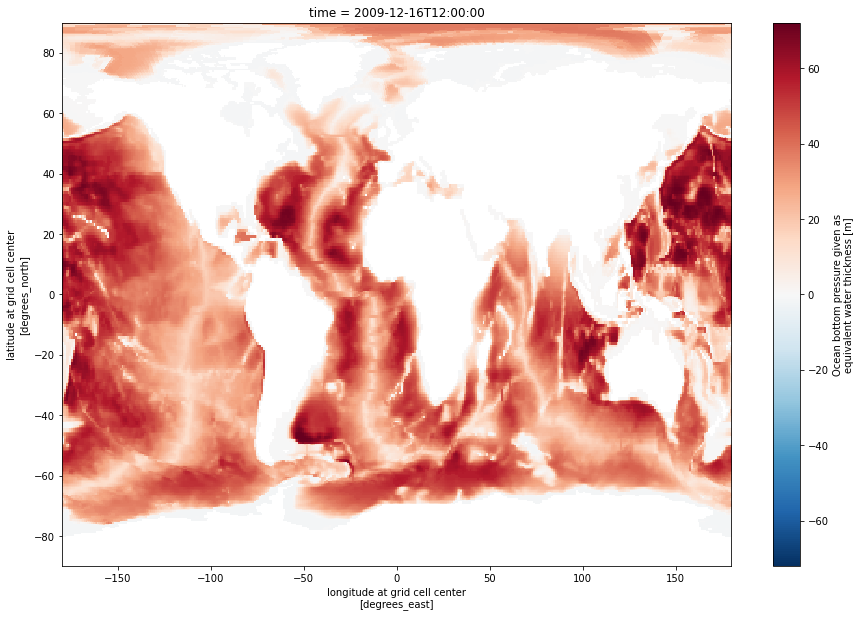

In [14]:
ds0 = xr.open_zarr(s3.get_mapper(s3_urls[0]), decode_cf=True, mask_and_scale=True)

# Mask the dataset where OBP is not within the bounds of the variable's valid min/max:
ds0_masked = ds0.where((ds0.OBP>=ds0.OBP.valid_min) & (ds0.OBP<=ds0.OBP.valid_max))

# Plot the masked dataset
ds0_masked.OBP.isel(time=0).plot.imshow(size=10)

**Load the zarr datasets into one large *xarray* dataset**

Load all the datasets in a loop and concatenate them:

In [15]:
zds = xr.concat([xr.open_zarr(s3.get_mapper(u)) for u in s3_urls], dim="time")

print(zds)

<xarray.Dataset>
Dimensions:         (latitude: 360, longitude: 720, nv: 2, time: 97)
Coordinates:
  * latitude        (latitude) float64 -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float64 -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
  * longitude       (longitude) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float64 -180.0 -179.5 -179.5 ... 179.5 180.0
  * time            (time) datetime64[ns] 2009-12-16T12:00:00 ... 2017-12-16T...
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    OBP             (time, latitude, longitude) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    OBPGMAP         (time, latitude, longitude) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet

Reference OBP and mask the dataset according to the valid minimum and maximum:

In [16]:
obp = zds.OBP

print(obp)

<xarray.DataArray 'OBP' (time: 97, latitude: 360, longitude: 720)>
dask.array<concatenate, shape=(97, 360, 720), dtype=float64, chunksize=(1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 2009-12-16T12:00:00 ... 2017-12-16T06:00:00
Attributes:
    comment:                OBP excludes the contribution from global mean at...
    coverage_content_type:  modelResult
    long_name:              Ocean bottom pressure given as equivalent water t...
    units:                  m
    valid_max:              72.07011413574219
    valid_min:              -1.7899188995361328


Get the valid min and max from the corresponding CF attributes:

In [17]:
obp_vmin, obp_vmax = obp.valid_min, obp.valid_max

obp_vmin, obp_vmax

(-1.7899188995361328, 72.07011413574219)

Mask the dataset according to the OBP min and max and plot a series:

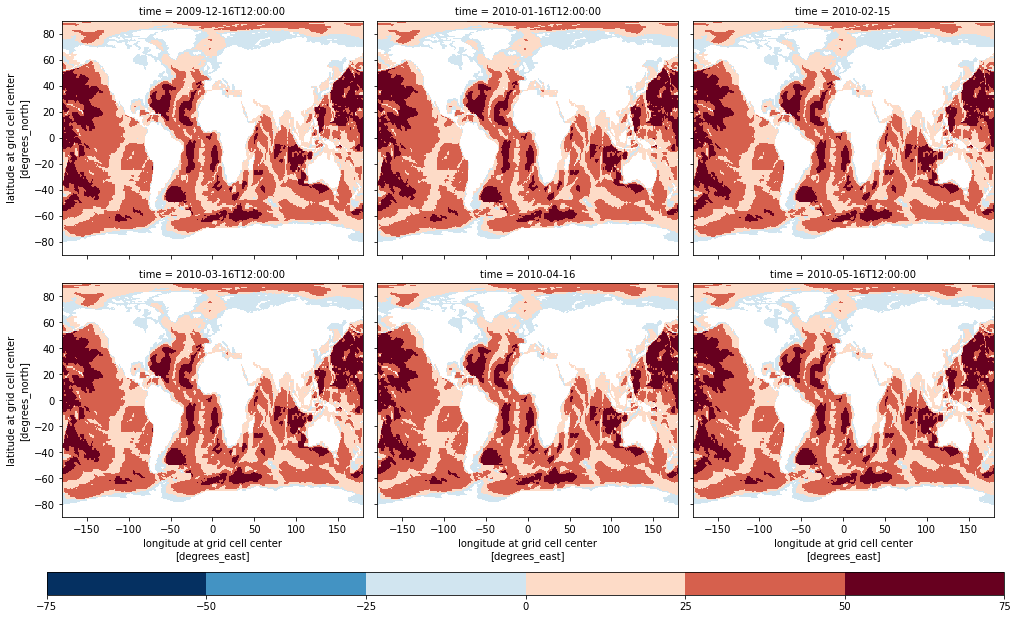

In [18]:
# Mask dataset where not inside OBP variable valid min/max:
zds_masked = zds.where((obp>=obp_vmin)&(obp<=obp_vmax))

# Plot SSH again for the first 12 time slices:
obpp = zds_masked.OBP.isel(time=slice(0, 6)).plot(
    x="longitude", 
    y="latitude", 
    col="time",
    levels=8,
    col_wrap=3, 
    add_colorbar=False,
    figsize=(14, 8)
)

# Plot a colorbar on a secondary axis
mappable = obpp.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.04, 0.95, 0.04])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')